In [1]:
#Imports
from scripts import bookdatafunctions as bdf
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Constants
JSON_PATH = "Parsed"
CONLLU_PATH = "Conllus"
ISBN2AGE_PATH = "ISBN_MAPS/ISBN2AGE.xlsx"

In [2]:
#Load corpus and map ages
corpus_ages_mapped = bdf.mapGroup2Age(bdf.cleanLemmas(bdf.initBooksFromConllus(CONLLU_PATH)), ISBN2AGE_PATH)

In [3]:
#Divide sub-corpora
ages = sorted(bdf.getAvailableAges(corpus_ages_mapped))
sub_corpora = [bdf.getDistinctSubCorp(corpus_ages_mapped, x) for x in ages]

In [4]:
#Grab stats necessary for Dispersion-calculations
word_amounts_total = bdf.getTokenAmounts(corpus_ages_mapped)
word_amounts_sub = [bdf.getTokenAmounts(x) for x in sub_corpora]

word_freqs = bdf.getWordFrequencies(corpus_ages_mapped)
word_freqs_sub = [bdf.getWordFrequencies(x) for x in sub_corpora]

lemma_freqs = bdf.getLemmaFrequencies(corpus_ages_mapped)
lemma_freqs_sub = [bdf.getLemmaFrequencies(x) for x in sub_corpora]

#The length of the corpus in words (no PUNCT)
sub_l = []
for i in range(len(ages)):
    sub_l.append(bdf.getL(word_amounts_sub[i]))
l = sum(sub_l)
#The length of the corpus in parts
n = len(corpus_ages_mapped.keys())
#The percentages of the n corpus part sizes
sub_s = []
for i in range(len(ages)):
    sub_s.append(bdf.getS(word_amounts_sub[i], sub_l[i]))
s = bdf.getS(word_amounts_total, l)
#The overall frequencies of words in corpus
sub_f_words = []
for i in range(len(ages)):
    sub_f_words.append(bdf.combineFrequencies(word_freqs_sub[i]))
f_words = bdf.combineFrequencies(word_freqs)
#The overall frequencies of lemmas in corpus
sub_f_lemmas = []
for i in range(len(ages)):
    sub_f_lemmas.append(bdf.combineFrequencies(lemma_freqs_sub[i]))
f_lemmas = bdf.combineFrequencies(lemma_freqs)
#The frequencies of words in each corpus part
v_words = word_freqs
#The frequencies of lemmas in each corpus part
v_lemmas = lemma_freqs

In [5]:
from tqdm import tqdm
#Function to calculate D (dispersion) of all the words in the corpus
def getDispersion(v: dict, f_series: pd.Series) -> pd.Series:
    """
    Function which calculates the dispersion of a word in a (sub)corpus
    :v: dict of form [book_name, pd.Series], series has frequencies per book
    :f_df: pd.Series that includes the total frequencies of words/lemmas in the whole corpus
    :return: pd.Series, with words/lemmas as indices and dispersions as values
    """

    words = [x[0] for x in f_series.index]
    v_prepped = {key:pd.Series(data=np.multiply(v[key].to_numpy(), np.log(v[key].to_numpy())),index=v[key].index) for key in v}
    corp_len = np.log(len(list(v.keys())))
    D = []
    with tqdm(range(len(f_series)), desc="D calculations") as pbar:
        #Loop through every single word in the corpus
        for word in words:
            #Get the freq of the word in the whole corpus
            f = f_series[word]
            # D = [log(p) * sum(p_i*log(p_i))/p]/log(n)
            #Calculate and append D
            D.append((np.log(f) - (np.sum([v_prepped[key].get(word,0.0) for key in v]) / f))/corp_len)
            #Update pbar
            pbar.update(1)
    return pd.Series(D, words)

In [6]:
v_words = bdf.getColumnFrequencies(sub_corpora[0], ['text'])
word_freqs = bdf.combineFrequencies(v_words)

In [7]:
word_D = bdf.getDispersion(v_words, word_freqs)
word_U = bdf.getU(v_words, word_freqs, word_D)
word_SFI = bdf.getSFI(word_U)


D calculations: 100%|██████████| 51692/51692 [00:04<00:00, 11222.89it/s]


In [8]:
#Whole corpus
M_whole = np.mean(word_U.values)
SD_whole = np.std(word_U.values)
min_whole = np.min(word_U.values)
max_whole = np.max(word_U.values)

print(M_whole)
print(SD_whole)
print(min_whole)
print(max_whole)

10.311476485117241
180.30704251079771
0.04708020992587822
29076.07897051934


In [121]:
#Whole corpus
M_whole = np.mean(word_SFI.values)
SD_whole = np.std(word_SFI.values)
min_whole = np.min(word_SFI.values)
max_whole = np.max(word_SFI.values)

print(M_whole)
print(SD_whole)
print(min_whole)
print(max_whole)

40.06796048093205
6.789580086417227
26.728383906507354
84.63535839728885


In [5]:
#Do Dispersion-calculations
#Whole corpus
lemma_DP, lemma_DP_norm = bdf.getDP(v_lemmas, f_lemmas, s)
#Sub-corpora
sub_lemma_dp = []
for i in range(len(ages)):
    sub_lemma_dp.append(bdf.getDP(lemma_freqs_sub[i], sub_f_lemmas[i], sub_s[i])[0])
#Whole corpus
word_DP, word_DP_norm = bdf.getDP(v_words, f_words, s)
#Sub-corpora
sub_word_dp = []
for i in range(len(ages)):
    sub_word_dp.append(bdf.getDP(word_freqs_sub[i], sub_f_words[i], sub_s[i])[0])

DP calculations: 100%|██████████| 9419/9419 [00:00<00:00, 37210.38it/s]


Values

In [19]:
#Whole corpus
M_whole = np.mean(lemma_DP.values)
SD_whole = np.std(lemma_DP.values)
min_whole = np.min(lemma_DP.values)
max_whole = np.max(lemma_DP.values)
per_10_whole = np.percentile(lemma_DP.values, 10)
per_25_whole = np.percentile(lemma_DP.values, 25)
per_50_whole = np.percentile(lemma_DP.values, 50)
per_75_whole = np.percentile(lemma_DP.values, 75)
per_90_whole = np.percentile(lemma_DP.values, 90)

In [20]:
#Prints for whole corpus
print("Mean ",M_whole)
print("SD ",SD_whole)
print("Min_whole", min_whole)
print("Max_Whole ",max_whole)
print("10th per ",per_10_whole)
print("25th per ",per_25_whole)
print("50th per ",per_50_whole)
print("75th per ",per_75_whole)
print("90th per ",per_90_whole)

Mean  0.9601696908626508
SD  0.09498028853407538
Min_whole 0.058100734328897896
Max_Whole  0.9997502656971349
10th per  0.9199603869726489
25th per  0.9762288755025141
50th per  0.988099708888357
75th per  0.993294350417764
90th per  0.9963321193179673


Plots

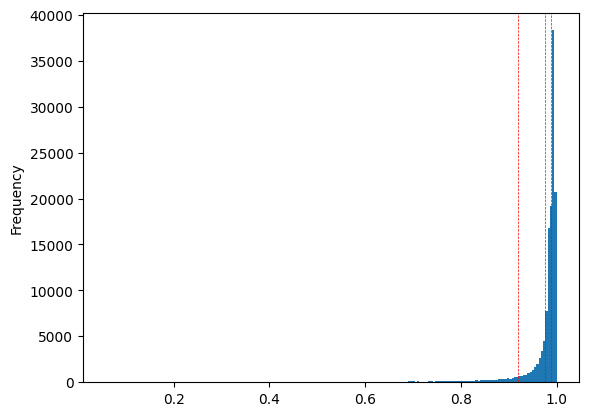

In [10]:
#Whole corpus
ax = lemma_DP.plot.hist(bins=200)
per_10 = np.percentile(lemma_DP.values, 10)
per_25 = np.percentile(lemma_DP.values, 25)
per_50 = np.percentile(lemma_DP.values, 50)
ax.axvline(per_10, color='r', linestyle='dashed', linewidth=0.5, label='60th Percentile')
ax.axvline(per_25, color='r', linestyle='dashed', linewidth=0.5, label='80th Percentile')
ax.axvline(per_50, color='r', linestyle='dashed', linewidth=0.5, label='90th Percentile')

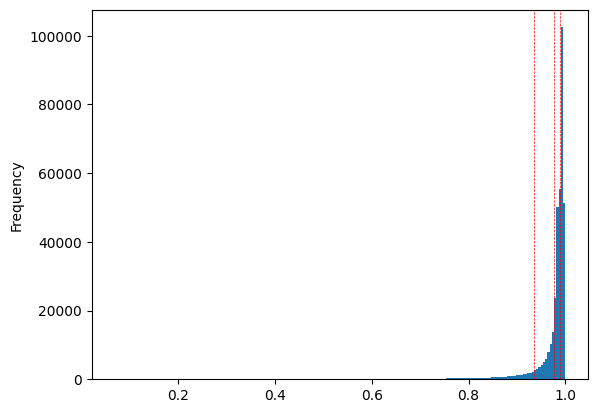

In [14]:
#Whole corpus
ax = word_DP.plot.hist(bins=200)
#ax.set_xlim(0.6,1)
per_10 = np.percentile(word_DP.values, 10)
per_25 = np.percentile(word_DP.values, 25)
per_50 = np.percentile(word_DP.values, 50)
ax.axvline(per_10, color='r', linestyle='dashed', linewidth=0.5, label='60th Percentile')
ax.axvline(per_25, color='r', linestyle='dashed', linewidth=0.5, label='80th Percentile')
ax.axvline(per_50, color='r', linestyle='dashed', linewidth=0.5, label='90th Percentile')